# Importing the libraries

In [112]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
import pyproj
import pandas as pd
import src.harmonize as hz
import sklearn as skl
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.widgets import Cursor
from matplotlib import animation


# Importing the dataset

In [113]:
# Create a path to the data directory
path_data = "C:/Users/luigi/OneDrive - Data ScienceTech Institute/Projet_PML/dataset/"

In [114]:
# Open the dataset list_xy and list_xdimydim
ds = xr.open_dataset( path_data + "datacube_gps_train_2017_2018.nc", decode_coords='all')
#list_xdimydim = xr.open_dataset(path_data + "list_xdimydim.nc", decode_coords='all')
ds


In [115]:
dynamic_variables = ['ET_500m']#,
"""                            'Fpar_500m',
                            'u10',
                            'v10',
                            't2m',
                            'tp',
                            'LST_Day_1km',
                            'LST_Night_1km',
                            '_1_km_16_days_EVI']"""

def get_df(the_ds, first_year=2015, last_year=2019, target_var='FireMask'):#, period_size=10, list_variables = []):
        """
        This function returns a dataframe from the dataset in the given period,
         dropping unnecessary variables and all NaN values
        input:
            the_ds: the dataset
        output:
            the_df: the dataframe
        """
        
        rus = RandomUnderSampler()
        
        # define an empty dataframe
        the_df = pd.DataFrame()
        
        # Divide the dataset into every year
        
        for year in range(first_year, last_year+1):
            
            # Define the dataset for the year
            the_df_year  = the_ds.sel(time=slice(str(year) + '-01-01', str(year) + '-12-30')).to_dataframe()

            # drop the columns we don't need anymore
            the_df_year = the_df_year.drop(columns = ["crs" , "band", "spatial_ref"])

            # Reshape FireMask variable          
                # drop the rows with NaN values
            the_df_year = the_df_year.dropna()
                # drop observations with FireMask = 0, 1 & 2 equivalent to NaN
            the_df_year = the_df_year[(the_df_year.FireMask != 0) & (the_df_year.FireMask != 1) & (the_df_year.FireMask != 2)]

            y_res = the_df_year[target_var].astype(int)

            # Get y_res binary
            y_res = y_res.replace([7, 8, 9], 1)
            y_res = y_res.replace([3, 4, 5], 0)

            # Add time x and y coordinates a new column
            the_df_year = the_df_year.reset_index()
                        
            # Reshape the dataframe
            the_df_year = rus.fit_resample(the_df_year, y_res)[0]
                              
            # Append the dataframe
            the_df = the_df.append(the_df_year)
            
        return the_df

df = get_df(ds, first_year=2017, last_year=2018, target_var='FireMask')#, period_size=3, list_variables = dynamic_variables)
df

In [116]:
#defining the function to get a period days time selection
def get_lastdays_mean_ds(the_ds, t=0, x=0, y=0, period_size=10, variable='u10'):
    """
    This function returns a the mean value of the selected pixel and the selected period of time
    input:
        the_ds: the dataset
        t: the time index
        x: the x index
        y: the y index
        period_size: the size of the period
        variable: the variable to be selected
    output:
        the mean value over the previous period_size days
        of the selected pixel and the selected period of time
    """

    mean_value = the_ds[variable].isel(x=x, y=y, time=slice(t-period_size-1, t-1)).mean(dim='time').values

    return mean_value


In [117]:
# add a new variable to the dataset
ds['u10_mean'] = (('x', 'y', 'time'), np.zeros((ds.x.size, ds.y.size, ds.time.size)))



In [ ]:
# define function to loop over the dataset to fill the new variable
dynamic_variables = ['ET_500m',
                        'Fpar_500m',
                        'u10',
                        'v10',
                        't2m',
                        'tp',
                        'LST_Day_1km',
                        'LST_Night_1km',
                        '_1_km_16_days_EVI']
def fill_ds_mean(the_ds, period_size=10, list_variables = []):
    """
    This function appends and fills the new variables of the dataset with the mean values,
    then drops the old ones.
    input:
        the_ds: the dataset
        period_size: the size of the period
        list_variables: the variables to be selected
    output:
        the dataset with the new variables filled
    """
    # Add a new variable to the dataset
    for var in list_variables:
        the_ds[var + '_last'+ str(period_size) + 'days' + '_mean'] = (('x', 'y',
         'time'), np.zeros((the_ds.x.size, the_ds.y.size, the_ds.time.size)))

    # loop over the dataset to fill the new variable
    for var in list_variables:
        for x in range(the_ds.x.size):
            for y in range(the_ds.y.size):
                for t in range(the_ds.time.size):
                    the_ds[var + '_last'+ str(period_size) + 'days' + '_mean'].values[x, y,
                    t] = get_lastdays_mean_ds(the_ds, t=t, x=x, y=y,
                    period_size=period_size, variable=var)
    
    # drop the old variables
    the_ds = the_ds.drop(dynamic_variables)

   
    return the_ds

ds

In [ ]:
# Generating the dataframe
df = ds.to_dataframe()

# Reshape FireMask variable
# drop observations with FireMask = 0, 1 & 2
df = df[(df.FireMask != 0) & (df.FireMask != 1) & (df.FireMask != 2)]

# drop the columns we don't need anymore
df = df.drop(columns = ["crs" , "band", "spatial_ref"])

In [ ]:
# Correlation matrix : 
cor = df.corr() 
plt.figure(figsize=(10, 10))
sns.heatmap(cor, square = True, cmap="coolwarm", linewidths=0.5, annot=True, xticklabels='auto', yticklabels='auto',)
#Pour choisr la couleur du heatmap : https://matplotlib.org/examples/color/colormaps_reference.html

<AxesSubplot:>

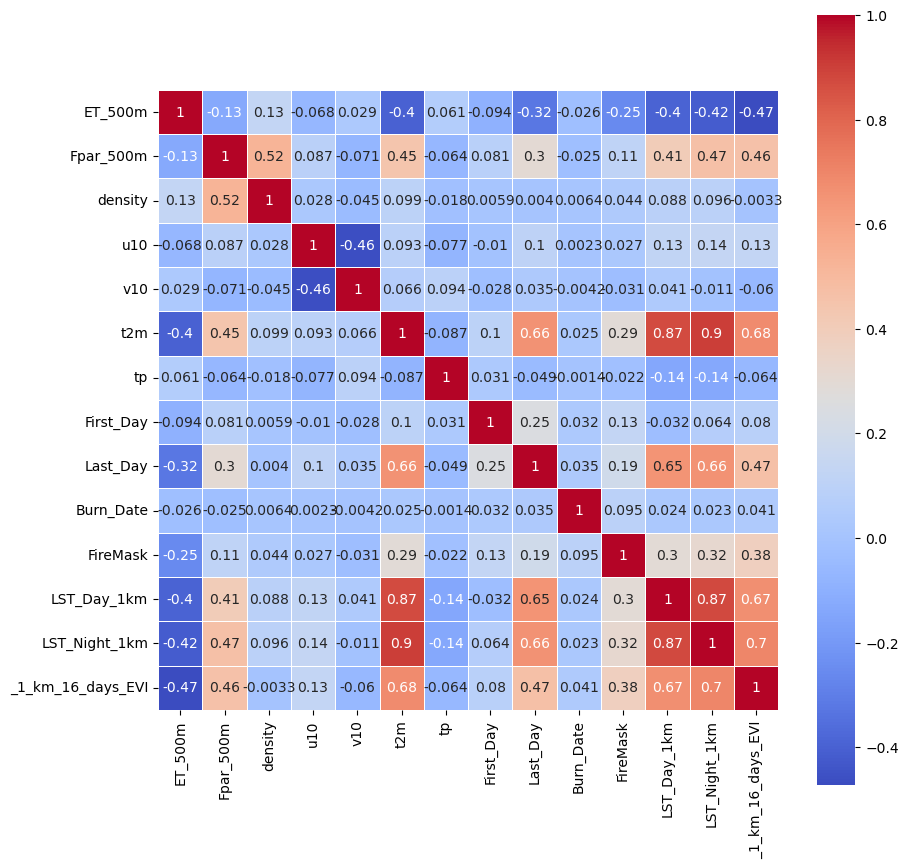

In [7]:
# define a function to get the correlation matrix and plot it
def get_correlation_matrix(the_df, target_var='FireMask'):
    """
    This function returns the correlation matrix of the dataframe
    input:
        the_df: the dataframe
    output:
        the correlation matrix
    """
    # Correlation matrix : 
    cor = the_df.corr() 
    plt.figure(figsize=(10, 10))
    sns.heatmap(cor, square = True, cmap="coolwarm", linewidths=0.5, annot=True, xticklabels='auto', yticklabels='auto',)
    
    
    # get the correlation matrix of the target variable
    #cor_target = abs(cor[target_var])
    # select the features with a correlation higher than 0.5
    #relevant_features = cor_target[cor_target>0.5]
    # print the features
    #print(relevant_features)
    
    return cor

# get the correlation matrix
cor = get_correlation_matrix(df)



In [4]:
# We drop the columns that are not relevant for the model
X = df.drop(columns = ["time", "FireMask"])
y = df[["FireMask"]].astype(int)
# group 7, 8 and 9 in True
#y = y.replace([7, 8, 9], 1)
# group 3, 4 and 5 in False
#y = y.replace([3, 4, 5], 0)
#y = y.replace(9, 7)



In [6]:
df = df.dropna()
# We drop the columns that are not relevant for the model
X = df
y = df[["FireMask"]].astype(int)
# group 7, 8 and 9 in True
y = y.replace([7, 8, 9], 1)
# group 3, 4 and 5 in False
y = y.replace([3, 4, 5], 0)
#y = y.replace(9, 7)

In [25]:
#Undersampling the dataframes to balance the classes
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)
#to remark that X_res, y_res lose their original index
#X_res
#rus.fit_resample(X, y)



# Cross Validation

In [ ]:
# First, define the models we want to use
# We use the default parameters for each model
# We use the same random state for each model to be able to compare them
# We use the class_weight parameter to balance the classes
# We use the max_iter parameter to avoid convergence warnings
# We use the n_estimators parameter to avoid convergence warnings
# We use the max_depth parameter to avoid convergence warnings
# We use the l1_ratio parameter to avoid convergence warnings

# Download the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Linear regression, k nearest neighbors, random forest, xgboost, lightgbm 
model_LR = skl.linear_model.LogisticRegression(C=0.05, l1_ratio=None, max_iter=10000)
model_KNN = skl.neighbors.KNeighborsClassifier()
model_RF = skl.ensemble.RandomForestClassifier(n_estimators=100, max_depth=2)
model_XGB = XGBClassifier(n_estimators=100, max_depth=2, use_label_encoder=False)
model_LGBM = LGBMClassifier(n_estimators=100, max_depth=2)

# put all those models in a list
models = [model_LR, model_KNN, model_RF, model_XGB, model_LGBM]



In [11]:
import datetime

In [ ]:
# Download the libraries for the cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# define a function to perform cross validation for the given models
def cross_validation(models, X, y, n_splits=10, random_state=71, stratified=True):
    """
    This function performs cross validation for the given models
    input:
        models: the models to be evaluated
        X: the features
        y: the target
        n_splits: the number of splits
        random_state: the random state
    output:
        a dataframe with the results
    """
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
    # Create conditional statement to check if stratified or not
    if stratified:
        # create a stratified k-fold object
        skf = StratifiedKFold(n_splits=n_splits, shuffle=False) #, random_state=random_state)
    else:
        # create a non stratified k-fold object
        skf = KFold(n_splits=n_splits, shuffle=False) #, random_state=random_state)
    # loop over the folds
    for train_index, test_index in skf.split(X, y):
        # split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # loop over the models
        for model in models:
            # fit the model
            time_0 = datetime.datetime.now()
            model.fit(X_train, np.ravel(y_train))
            time_1 = datetime.datetime.now()
            # predict the target
            y_pred = model.predict(X_test)
            # compute the accuracy
            accuracy = accuracy_score(y_test, y_pred)
            # compute the precision
            precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
            # compute the recall
            recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
            # compute the f1 score
            f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
            # compute the time to fit the model in seconds
            time_fit = (time_1 - time_0).total_seconds()

            # store the results in the dataframe sorted by accuracy
            results = results.append({'model': model.__class__.__name__,
                                      'accuracy': accuracy,
                                      'precision': precision,
                                      'recall': recall,
                                      'f1': f1,
                                      'Time to fit': time_fit}, ignore_index=True)

            # sort the results by accuracy
            # results = results.sort_values(by='accuracy', ascending=False)

            # group the results by model
            results = results.groupby('model').mean().reset_index().sort_values(by='accuracy',
                             ascending=False).reset_index(drop=True)

    # return the dataframe
    return results

# perform the 10-fold cross validation
results = cross_validation(models, X, y, n_splits=10, random_state=71, stratified=False)
results




In [ ]:
# k-fold cross validation on Logistic Regression model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_LR = skl.linear_model.LogisticRegression(C=0.05, l1_ratio=None, max_iter=10000)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
     
    #Train the model
    model_LR.fit(X_train, np.ravel(y_train,order='C')) #Training the model 
    
    #Evaluate the acuracy of the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_LR.predict(X_test))}, doublecheck: {model_LR.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_LR.predict(X_test)))
    i += 1
Accuracy_array
# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

In [ ]:
# k-fold cross validation on K-Nearst Neighbors model
from sklearn.neighbors import KNeighborsClassifier

model_KNN = skl.neighbors.KNeighborsClassifier()
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
     
    #Train the model
    model_KNN.fit(X_train, np.ravel(y_train,order='C')) #Training the model 
    
    #Evaluate the acuracy of the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_LR.predict(X_test))}, doublecheck: {model_LR.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_LR.predict(X_test)))
    i += 1

# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

In [ ]:
# K-fold cross validation on random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=71)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    print('Fold: {}'.format(i))
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #Train the model
    model_RF.fit(X_train, np.ravel(y_train, order='C'))
    
    #Predict the response for test dataset
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_RF.predict(X_test))}, doublecheck: {model_RF.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_RF.predict(X_test)))
    i += 1
    
# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

In [13]:
from xgboost import XGBClassifier

In [ ]:
# K-fold cross validation on random XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_XGB = XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    print('Fold: {}'.format(i))
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #Train the model
    model_XGB.fit(X_train, np.ravel(y_train, order='C'))
    
    #Predict the response for test dataset
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_XGB.predict(X_test))}, doublecheck: {model_XGB.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_XGB.predict(X_test)))
    i += 1

# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")



In [6]:
from lightgbm import LGBMClassifier

In [ ]:
# K-fold cross validation on random lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_LGBM = LGBMClassifier(n_estimators=100, max_depth=2, random_state=71)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    print('Fold: {}'.format(i))
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #Train the model
    model_LGBM.fit(X_train, np.ravel(y_train, order='C'))
    
    #Predict the response for test dataset
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_LGBM.predict(X_test))}, doublecheck: {model_LGBM.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_LGBM.predict(X_test)))
    i += 1

# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")


In [ ]:
# get time column
time_col = df['time']
# get first 4 digits of time column
time_col = time_col.apply(lambda x: str(x)[:4])
# convert to int
time_col = time_col.astype(int)
time_col

In [ ]:
# Split the data into train on 2010 to 2017 and test on 2018 to 2020
df_train = df[df['time'].apply(lambda x: str(x)[:4]).astype(int) < 2018]
df_test = df[df['time'].apply(lambda x: str(x)[:4]).astype(int) >= 2018]


In [4]:
df = pd.read_csv(path_data + "df_final.csv", parse_dates=["time"])
# Split the data into train and test
df_train = df[df["time"] < "2018-01-01"]
df_test = df[df["time"] >= "2018-01-01"]


In [12]:
import pickle

def fit_lgbm_model(the_df_train, n_estimators=100, max_depth=2, path_data=""):
    """
    This function fits a lgmb model
    input:
        the_df_train: the dataframe
        n_estimators: the number of estimators
        max_depth: the maximum depth
        path_data: the path where to save the pickle file
    output:
        the model
    """
    # define the model
    model = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth)
    # define the features and the target
    X_train = the_df_train.drop(['time','FireMask'], axis=1)
    y_train = the_df_train['FireMask'].astype(int)
    # fit the model
    time_start = datetime.datetime.now()
    model.fit(X_train, y_train)
    time_end = datetime.datetime.now()
    # Add the time as model attribute
    model.time = (time_end - time_start).total_seconds()
    # save the pickle file
    #pickle.dump(model, open('model_lgbm.pkl', 'wb'))
    # generate the pickle file
    pickle.dump(model, open(path_data + 'model_lgbm.pkl', 'wb'))
    # return the pickle
    return model

lgbm_model = fit_lgbm_model(df_train, n_estimators=100, max_depth=2, path_data=path_data)

In [13]:
#get time to fit the model in datetime format
lgbm_model.time


0.129994

In [55]:
# generate the pickle file
pickle.dump(lgbm_model, open(path_data + 'model_lgbm.pkl', 'wb'))


In [14]:
def predict_lgbm_model(the_df_test, model):
    """
    This function predicts the lgbm model
    input:
        the_df_test: the tet dataframe
        model: the model
    output:
        the predictions
    """
    # define the features
    X_test = the_df_test.drop(['time','FireMask'], axis=1)
    # predict the model
    y_pred = model.predict(X_test)
    # give the perobabilities of the predictions
    y_pred_proba = model.predict_proba(X_test)
    # Add the predictions and the probabilities to the dataframe
    #the_df_test['FireMask_pred'] = y_pred
    #the_df_test['FireMask_proba'] = y_pred_proba[:,1]

    # Stack the prediction with the time and target
    the_df_pred = pd.DataFrame({"time":the_df_test["time"], "FireMask": the_df_test["FireMask"].astype(int),
                                "FireMask_pred": y_pred, "FireMask_proba": y_pred_proba[:, 1]})
    
    # return the the dataframe
    return the_df_pred

df_pred = predict_lgbm_model(df_test, lgbm_model)
df_pred

,time,FireMask,FireMask_pred,FireMask_proba
22558,2018-08-17,1,0,0.286378
22559,2018-08-18,1,0,0.286378
22560,2018-08-19,1,0,0.286378
22561,2018-08-20,1,0,0.302589
22562,2018-08-21,1,0,0.302589
...,...,...,...,...
29177,2020-11-09,0,0,0.143328
29178,2020-05-16,0,0,0.211722
29179,2020-02-13,0,1,0.644748
29180,2020-02-05,0,0,0.237348


In [16]:
# import the libraries

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# define a function to plot accuracy, precision, recall, f1-score
def plot_metrics(model, y_test, y_pred):
    """
    This function plots the accuracy, precision, recall, f1-score
    input:
        y_test: the test target
        y_pred: the predictions
    output:
        None
    """
    results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
    # compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # plot the metrics
    results = results.append({'model': model.__class__.__name__,
                                      'accuracy': accuracy,
                                      'precision': precision,
                                      'recall': recall,
                                      'f1': f1,
                                      'time to fit [s]': model.time
                                      }, ignore_index=True)
    return results

resultas = plot_metrics(lgbm_model, df_pred['FireMask'], df_pred['FireMask_pred'].astype(int))
resultas

,model,accuracy,precision,recall,f1,time to fit [s]
0,LGBMClassifier,0.780646,0.806664,0.738225,0.770929,0.129994


In [150]:
# save the dataframe to csv
df_pred.to_csv(path_data + "df_pred.csv", index=False)

In [151]:
df_test

,x,y,time,density,First_Day,Last_Day,Burn_Date,FireMask,ET_500m_mean,Fpar_500m_mean,u10_mean,v10_mean,t2m_mean,tp_mean,LST_Day_1km_mean,LST_Night_1km_mean,_1_km_16_days_EVI_mean
22558,4.337576,44.430909,2018-08-17,65.063034,207.411290,279.903226,0.0,1.0,16.230000,0.584072,0.419922,-1.000133,293.199289,0.004510,301.407863,289.563687,0.380487
22559,4.337576,44.430909,2018-08-18,65.063034,208.483871,280.709677,0.0,1.0,16.100002,0.585918,0.456385,-1.454020,292.898217,0.004733,301.139173,289.720516,0.382837
22560,4.337576,44.430909,2018-08-19,65.063034,209.556452,281.516129,0.0,1.0,15.850001,0.587551,0.431329,-1.913773,292.856045,0.004273,301.387495,290.000703,0.385432
22561,4.337576,44.430909,2018-08-20,65.063034,210.629032,282.322581,0.0,1.0,15.600000,0.588971,0.459216,-1.988419,293.172901,0.001606,301.535495,290.404703,0.388272
22562,4.337576,44.430909,2018-08-21,65.063034,211.701613,283.129032,0.0,1.0,15.350000,0.590178,0.499901,-2.060565,293.591260,0.001606,301.630000,290.748497,0.391357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,6.368977,44.678641,2020-11-09,1.219522,303.233333,330.133333,0.0,0.0,3276.500000,0.210865,-0.744626,-0.512833,274.738078,0.000372,282.273217,272.741976,0.142431
29178,5.308685,43.519256,2020-05-16,62.826794,117.935484,190.032258,0.0,0.0,22.600000,0.600984,-0.620881,0.019610,288.015295,0.002085,296.151572,288.335298,0.364459
29179,4.377214,44.787643,2020-02-13,3.489132,35.017241,87.482759,0.0,0.0,3276.500000,0.407908,1.204479,-0.460502,276.489115,0.000287,279.911783,275.180564,0.192178
29180,5.724875,44.193087,2020-02-05,1.912674,15.413793,77.206897,0.0,0.0,7.139999,0.514080,0.833045,-1.375424,276.273282,0.001132,283.015223,275.484973,0.332222


In [152]:
# Add the predictions and the probabilities to the dataframe
df_test['FireMask_pred'] = df_pred['FireMask_pred']
df_test['FireMask_proba'] = df_pred['FireMask_proba']
df_test


c:\Users\luigi\anaconda3\envs\tamere_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\luigi\anaconda3\envs\tamere_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x,y,time,density,First_Day,Last_Day,Burn_Date,FireMask,ET_500m_mean,Fpar_500m_mean,u10_mean,v10_mean,t2m_mean,tp_mean,LST_Day_1km_mean,LST_Night_1km_mean,_1_km_16_days_EVI_mean,FireMask_pred,FireMask_proba
22558,4.337576,44.430909,2018-08-17,65.063034,207.411290,279.903226,0.0,1.0,16.230000,0.584072,0.419922,-1.000133,293.199289,0.004510,301.407863,289.563687,0.380487,0,0.286378
22559,4.337576,44.430909,2018-08-18,65.063034,208.483871,280.709677,0.0,1.0,16.100002,0.585918,0.456385,-1.454020,292.898217,0.004733,301.139173,289.720516,0.382837,0,0.286378
22560,4.337576,44.430909,2018-08-19,65.063034,209.556452,281.516129,0.0,1.0,15.850001,0.587551,0.431329,-1.913773,292.856045,0.004273,301.387495,290.000703,0.385432,0,0.286378
22561,4.337576,44.430909,2018-08-20,65.063034,210.629032,282.322581,0.0,1.0,15.600000,0.588971,0.459216,-1.988419,293.172901,0.001606,301.535495,290.404703,0.388272,0,0.302589
22562,4.337576,44.430909,2018-08-21,65.063034,211.701613,283.129032,0.0,1.0,15.350000,0.590178,0.499901,-2.060565,293.591260,0.001606,301.630000,290.748497,0.391357,0,0.302589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,6.368977,44.678641,2020-11-09,1.219522,303.233333,330.133333,0.0,0.0,3276.500000,0.210865,-0.744626,-0.512833,274.738078,0.000372,282.273217,272.741976,0.142431,0,0.143328
29178,5.308685,43.519256,2020-05-16,62.826794,117.935484,190.032258,0.0,0.0,22.600000,0.600984,-0.620881,0.019610,288.015295,0.002085,296.151572,288.335298,0.364459,0,0.211722
29179,4.377214,44.787643,2020-02-13,3.489132,35.017241,87.482759,0.0,0.0,3276.500000,0.407908,1.204479,-0.460502,276.489115,0.000287,279.911783,275.180564,0.192178,1,0.644748
29180,5.724875,44.193087,2020-02-05,1.912674,15.413793,77.206897,0.0,0.0,7.139999,0.514080,0.833045,-1.375424,276.273282,0.001132,283.015223,275.484973,0.332222,0,0.237348
